# matchms tutorial
## part II - compute spectra similarities using Spec2Vec
This is part of a matchms and Spec2Vec tutorial.  
Part I --> https://blog.esciencecenter.nl/build-your-own-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-i-d96c718c68ee

Part II --> https://blog.esciencecenter.nl/build-a-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-ii-spec2vec-8aa639571018

Here we will start with data that was processed in the part I notebook.
See notebook part I: https://github.com/matchms/matchms/blob/master/tutorial/matchms_tutorial_01_building_analysis_pipeline.ipynb


### Requirements
For this notebook to work, both `matchms` and `Spec2Vec` need to be installed.
This can be done by running:

```
conda create --name spec2vec python=3.8
conda activate spec2vec
conda install --channel bioconda --channel conda-forge matchms spec2vec
```
Here we used `spec2vec 0.8.0` and `matchms 0.18.0`.

## Import data
- We will here use data that was imported and processed in the notebook on part I.

In [1]:
# Check versions
import matchms
import spec2vec
print("matchms:", matchms.__version__)
print("spec2vec", spec2vec.__version__)

matchms: 0.18.0
spec2vec 0.8.0


In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matchms.importing import load_from_json

path_data = os.path.join(os.path.dirname(os.getcwd()), "data") #"..." enter your pathname to the downloaded file
file_json = os.path.join(path_data, "GNPS-NIH-NATURALPRODUCTSLIBRARY_processed.json")
spectrums = list(load_from_json(file_json))

In [3]:
print(f"{len(spectrums)} spectrums found and imported")

1267 spectrums found and imported


---

# Spec2Vec
## Computing spectra similarities between all spectra using Spec2Vec
In the following part spectra similarities will be calculated using Spec2Vec. Spec2Vec is an unsupervised machine learning technique that can learn relationships between peaks from larger spectra datasets.

Spec2Vec can be used in two fundamentally different ways.

**(1)** Loading a Spec2Vec model which was pretrained on a large MS/MS dataset. 

**(2)** A Spec2Vec model can be trained on the dataset of interest itself. This requires a sufficiently large datasets (at least several hundreds of spectra).


We will do both things in the following part of this notebook.

## 1. Load a pretrained Spec2Vec model
For many use-cases we would not advice to retrain a new model from scratch. Instead a more general model that has been trained on a large MS/MS dataset can simply be loaded and used to calculate similarities, even for spectra which were not part of the initial model training.

Here we can download a model trained on about 95,000 spectra from GNPS (positive ionmode) which we provide here: https://zenodo.org/record/4173596.

Let's now load this model:

In [15]:
from pathlib import Path


path_model = os.path.join(Path(os.getcwd()).parents[2],
                          "Data", "trained_models") #"..." enter your pathname to the downloaded file

In [18]:
import gensim

filename_model = "spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model"
filename = os.path.join(path_model, filename_model)

model = gensim.models.Word2Vec.load(filename)

It is very important to make sure that the "documents" are created the same way as for the model training. This mostly comes down here to the number of decimals which needs to be the same here than for the pretrained model. To inspect the words the model has learned, we can look at `model.wv` which is the "vocabulary" the model has learned.

In [19]:
model.wv.index_to_key[0]  # shows the first word in vocabulary

'peak@105.07'

In [20]:
print(f"Learned vocabulary contains {len(model.wv)} words.")

Learned vocabulary contains 115910 words.


This means the model will expect words with 2 decimals!

## Compute similarities

In [21]:
from matchms import calculate_scores
from spec2vec import Spec2Vec

spec2vec_similarity = Spec2Vec(model=model,
                               intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)

scores = calculate_scores(spectrums, spectrums, spec2vec_similarity,
                          is_symmetric=True)

## Get highest scoring results for a spectrum of interest

In [22]:
best_matches = scores.scores_by_query(spectrums[11], sort=True)[:10]
[x[1] for x in best_matches]

[0.9999999999999996,
 0.6323327469158131,
 0.6094968210816917,
 0.563365165096553,
 0.5322113813011992,
 0.5311480111999453,
 0.49455675109741976,
 0.48921947174118874,
 0.46979465313015495,
 0.40925116562265457]

In [23]:
[x[0].get("smiles") for x in best_matches]

['CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CC(=O)O)C(=O)O',
 'CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@H](C(=O)O)c3ccccc3',
 'CCCCCC(NC(=O)C1CCN(CC1)C(=O)[C@@H](NS(=O)(=O)c2ccc(C)cc2)C(C)C)C(=O)O',
 'CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CCC(=O)N)C(=O)O',
 'CC(C)C[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](C(C)C)C(=O)O',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@H](C(=O)O)c3ccccc3',
 'COC(=O)C1CCN(CC1)C(=O)C2CCN(CC2)C(=O)[C@@H](NS(=O)(=O)c3ccc(C)cc3)C(C)C',
 'CC(C)C[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](Cc3ccccc3)C(=O)O',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N3CCC(CC3)C(=O)N',
 'CSCC[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](Cc3ccc(O)cc3)C(=O)O']

In [24]:
from rdkit import Chem
from rdkit.Chem import Draw

for i, smiles in enumerate([x[0].get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    Draw.MolToFile(m, f"compound_{i}.png")

In [25]:
best_matches = scores.scores_by_query(spectrums[5], sort=True)[:10]
[x[1] for x in best_matches]

[1.0,
 0.9346579480830896,
 0.9259069095210206,
 0.8994992281075841,
 0.8889616172843696,
 0.886971469689494,
 0.8856347491436403,
 0.8797176569221946,
 0.8053718973741254,
 0.8041226578863799]

In [26]:
from rdkit import Chem
from rdkit.Chem import Draw

for i, smiles in enumerate([x[0].get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    Draw.MolToFile(m, f"compound_{i}.png")

In [27]:
[x[0].get("smiles") for x in best_matches]

['OC(COC(=O)c1ccccc1)C(O)C(O)COC(=O)c2ccccc2',
 'Cc1cc(=O)oc2cc(OC(=O)c3ccccc3)ccc12',
 'O=C(Nc1ccccc1OC(=O)c2ccccc2)c3ccccc3',
 'COC(=O)CNC(=O)c1ccccc1',
 'O=C(Oc1cccc2ccccc12)c3ccccc3',
 'O=C(N1CCCCC1)c2ccccc2',
 'O=C(OCC1OC(C(OC(=O)c2ccccc2)C1OC(=O)c3ccccc3)n4ncc(=O)[nH]c4=O)c5ccccc5',
 'COc1cc(CC=C)ccc1OC(=O)c2ccccc2',
 'O=C(N1[C@@H](C#N)C2OC2c3ccccc13)c4ccccc4',
 'COc1cc(/C=C(\\NC(=O)c2ccccc2)/C(=O)NC(C(=O)O)c3ccccc3)cc(OC)c1OC']

Those smiles can be beter inspected by plotting the corresponding chemical structures, e.g. using rdkit:

In [28]:
from rdkit import Chem
from rdkit.Chem import Draw

for i, smiles in enumerate([x[0].get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    Draw.MolToFile(m, f"compound_{i}.png")

## Visualize the results

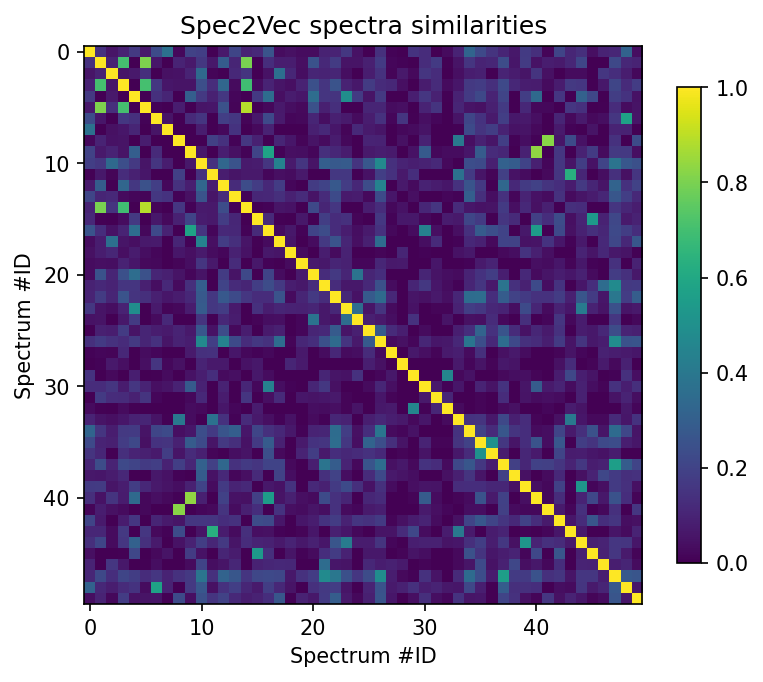

In [30]:
scores_array = scores.scores.to_array()

plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores_array[:50, :50], cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("Spec2Vec spectra similarities")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")
plt.clim(0, 1)  # Spec2Vec scores can be between -1 and 1
#plt.savefig("spec2vec_scores.pdf")

## 2. Train a new Spec2Vec model from scratch
Training a Spec2Vec model is fairly straightforward and relatively fast. In general, training a new model from scratch makes sense when a lot a data is present to train on as it gives more options to optimize the results when compared to simply using a pretrained model as done above.

First we create "spectrum documents" from the imported and processed spectra:

In [31]:
from spec2vec import SpectrumDocument

spectrum_documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums]

In [32]:
len(spectrum_documents)

1267

Then we train a new model on the 1267 found spectra. This can take a few minutes to train.

In [33]:
from spec2vec.model_building import train_new_word2vec_model

model_file = "tutorial_model.model"
model = train_new_word2vec_model(spectrum_documents, iterations=[25], filename=model_file,
                                 workers=2, progress_logger=True)

  Epoch 1 of 25.Change in loss after epoch 1: 274233.46875
  Epoch 2 of 25.Change in loss after epoch 2: 210155.0
  Epoch 3 of 25.Change in loss after epoch 3: 195759.53125
  Epoch 4 of 25.Change in loss after epoch 4: 186267.0625
  Epoch 5 of 25.Change in loss after epoch 5: 177802.1875
  Epoch 6 of 25.Change in loss after epoch 6: 173029.75
  Epoch 7 of 25.Change in loss after epoch 7: 160432.0
  Epoch 8 of 25.Change in loss after epoch 8: 155855.625
  Epoch 9 of 25.Change in loss after epoch 9: 152814.25
  Epoch 10 of 25.Change in loss after epoch 10: 148126.375
  Epoch 11 of 25.Change in loss after epoch 11: 144889.375
  Epoch 12 of 25.Change in loss after epoch 12: 141123.625
  Epoch 13 of 25.Change in loss after epoch 13: 135344.25
  Epoch 14 of 25.Change in loss after epoch 14: 132145.75
  Epoch 15 of 25.Change in loss after epoch 15: 129755.0
  Epoch 16 of 25.Change in loss after epoch 16: 128193.75
  Epoch 17 of 25.Change in loss after epoch 17: 124447.0
  Epoch 18 of 25.Chang

## Compute similarities
Here, we will:
- load our just trained model
- compute all similarites between the spectra

In [34]:
#optional: load the model if you trained it already before:
import gensim

model = gensim.models.Word2Vec.load("tutorial_model.model")

In [35]:
from matchms import calculate_scores
from spec2vec import Spec2Vec

spec2vec_similarity = Spec2Vec(model=model, intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)

scores = calculate_scores(spectrum_documents, spectrum_documents, spec2vec_similarity, is_symmetric=True)

## Get highest scoring results for a spectrum of interest

In [44]:
best_matches = scores.scores_by_query(spectrum_documents[11], sort=True)[:10]
[x[1] for x in best_matches]

[0.9999999999999996,
 0.8811375159293446,
 0.8785382240817112,
 0.8674065549558589,
 0.8634502875484844,
 0.86344719988381,
 0.8629959603674551,
 0.8373854805544433,
 0.8366474848814489,
 0.8327883009327168]

In [45]:
[x[0].get("smiles") for x in best_matches]

['CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CC(=O)O)C(=O)O',
 'CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CCC(=O)N)C(=O)O',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@H](C(=O)O)c3ccccc3',
 'CCCCCC(NC(=O)C1CCN(CC1)C(=O)[C@@H](NS(=O)(=O)c2ccc(C)cc2)C(C)C)C(=O)O',
 'CC(C)C[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](C(C)C)C(=O)O',
 'CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@H](C(=O)O)c3ccccc3',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N3CCC(CC3)C(=O)N',
 'CC(C)C[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](Cc3ccccc3)C(=O)O',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N3CCC(CC3)C(=O)OC',
 'COC(=O)C1CCN(CC1)C(=O)C2CCN(CC2)C(=O)[C@@H](NS(=O)(=O)c3ccc(C)cc3)C(C)C']

Those smiles can be beter inspected by plotting the corresponding chemical structures, e.g. using rdkit:

In [46]:
from rdkit import Chem
from rdkit.Chem import Draw

for i, smiles in enumerate([x[0].get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    Draw.MolToFile(m, f"compound_{i}.png")

In [36]:
from rdkit.Chem.Draw import rdMolDraw2D

smiles = 'CCC(C)C[C@H](NS(=O)(=O)c1ccc(CC)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](Cc3ccccc3)C(=O)O'
d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
m = Chem.MolFromSmiles(smiles)
d2d.DrawMolecule(m)
d2d.FinishDrawing()
text1 = d2d.GetDrawingText()

file1 = open("compound1_test.svg","w")
for line in text1:
    file1.write(line) 
file1.close() 

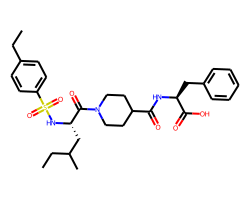

In [38]:
from IPython.display import SVG

SVG(d2d.GetDrawingText())

## Visualize the results

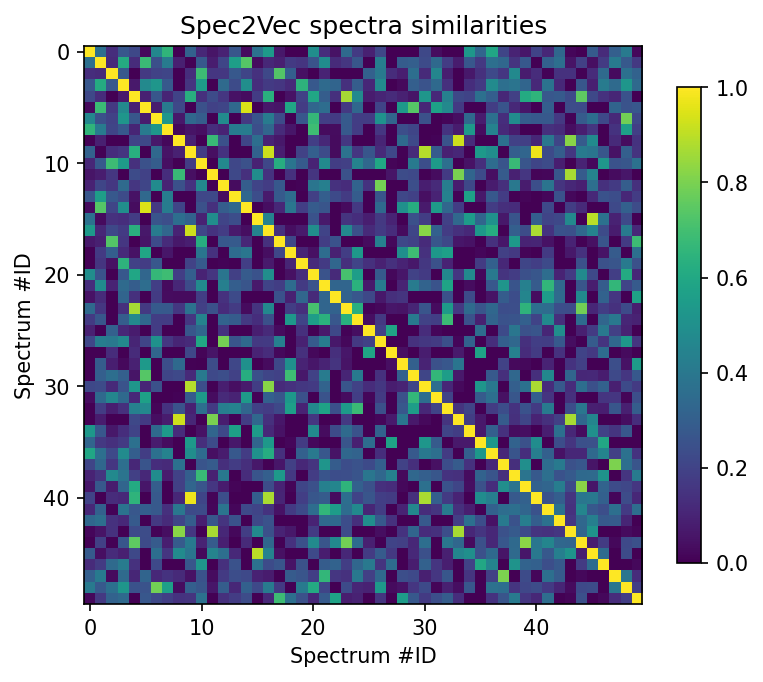

In [40]:
scores_array = scores.scores.to_array()

plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores_array[:50, :50], cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("Spec2Vec spectra similarities")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")
plt.clim(0, 1)  # Spec2Vec scores can be between -1 and 1
#plt.savefig("spec2vec_scores.png")